In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.is_available()

True

In [1]:
from Data_train import epoch 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
import numpy as np

# X, Y = create_epoch()




# with open("Data_train/Saved/arrayX.txt", "a") as arrayX:
#           np.savetxt(arrayX, X, delimiter=",", fmt='%.4f')

# with open("Data_train/Saved/arrayY.txt", "a") as arrayY:
#           np.savetxt(arrayY, Y, delimiter=",", fmt='%.4f')


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [3]:
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

In [6]:
X = np.loadtxt("/home/it/Desktop/NTMINH/Data/Data/data_train/arrayX_train_30_30_30_7_days_pred_7_days_2020.txt", delimiter=",")
Y = np.loadtxt("/home/it/Desktop/NTMINH/Data/Data/data_train/arrayY_train_30_30_30_7_days_pred_7_days_2020.txt", delimiter=",")

seq x input_dim = 3 x 30

output_dim = 7

In [8]:
X[0]

array([2.70000e+01, 2.80000e+01, 1.40000e+01, 1.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.90000e+01,
       1.30000e+01, 1.30000e+01, 1.00000e+01, 6.40000e+01, 8.00000e+00,
       1.10000e+01, 3.80000e+01, 1.10000e+01, 8.00000e+00, 5.00000e+00,
       4.00000e+00, 7.00000e+00, 4.00000e+00, 6.00000e+00, 6.00000e+00,
       9.00000e+00, 8.00000e+00, 1.10000e+01, 1.60000e+01, 7.00000e+00,
       6.54650e+00, 4.45350e+00, 3.34880e+00, 2.20900e-01, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.54650e+00,
       2.09300e+00, 4.31400e+00, 4.13950e+00, 1.44767e+01, 6.29070e+00,
       7.25580e+00, 1.78721e+01, 5.87210e+00, 5.58140e+00, 5.53490e+00,
       2.83720e+00, 2.65120e+00, 2.59300e+00, 2.06980e+00, 1.82560e+00,
       1.98840e+00, 2.51160e+00, 2.75580e+00, 3.43020e+00, 4.32560e+00,
       1.54470e+00, 9.81600e-01, 9.64500e-01, 4.90000e-02, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.011

In [4]:
# Giữ lại một số sku để test
sku_test = 103
sku_train = round(X.shape[0]/329.0 - sku_test)

In [5]:

day_temp = 329

In [6]:
# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = X[:sku_train*day_temp], X[sku_train*day_temp:], Y[:sku_train*day_temp], Y[sku_train*day_temp:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(263200, 97)
(33887, 97)
(263200, 7)
(33887, 7)


In [7]:
# model.load(X_train, y_train)
# print(model)
model.load_model('/home/it/Desktop/NTMINH/Data/Data/data_train/model_train_30_30_30_7_days_pred_7_days_2020')

In [8]:
# make predictions for test data
y_pred = model.predict(X_test)

In [9]:
np.sqrt(np.square(np.subtract(y_test, y_pred))).sum()/y_test.shape[0]

8.31807765565071

In [10]:
y_pred_int = np.asarray(y_pred, dtype = np.int32)
y_pred_int[y_pred_int < 0] = 0

In [11]:

print('Số lượng lable > 0',len(y_test[y_test > 0]))
print('Số lượng lable == 0',len(y_test[y_test == 0]))

print('Số lượng pred > 0',len(y_pred_int[y_pred_int > 0]))
print('Số lượng pred == 0',len(y_pred_int[y_pred_int == 0]))
print('Số lượng pred == 0',len(y_pred_int[y_pred_int < 0]))

Số lượng lable > 0 113675
Số lượng lable == 0 123534
Số lượng pred > 0 108606
Số lượng pred == 0 128603
Số lượng pred == 0 0


In [12]:
# Tỉ lệ khi label = 0 và dự đoán đoán đúng

total = len(y_test[y_test == 0])
acc = np.sum((y_test == 0) & (y_pred_int == 0))
acc/total

0.7804167273786974

In [13]:
# Tỉ lệ đoán khác 0 khi dữ liệu thật khác 0

total = len(y_test[y_test != 0])
acc = ((y_test != 0) & (y_pred_int != 0)).sum()
acc/total

0.7167802946998021

In [14]:
condition = np.where(y_test != 0)
np.sqrt(np.square(np.subtract(y_test[condition], y_pred[condition]))).sum()/y_test.shape[0]

5.880807407902447

In [15]:
print(np.max(np.subtract(y_test[condition], y_pred[condition])))
print(np.min(np.subtract(y_test[condition], y_pred[condition])))

224.92164194583893
-80.68612670898438


<AxesSubplot:>

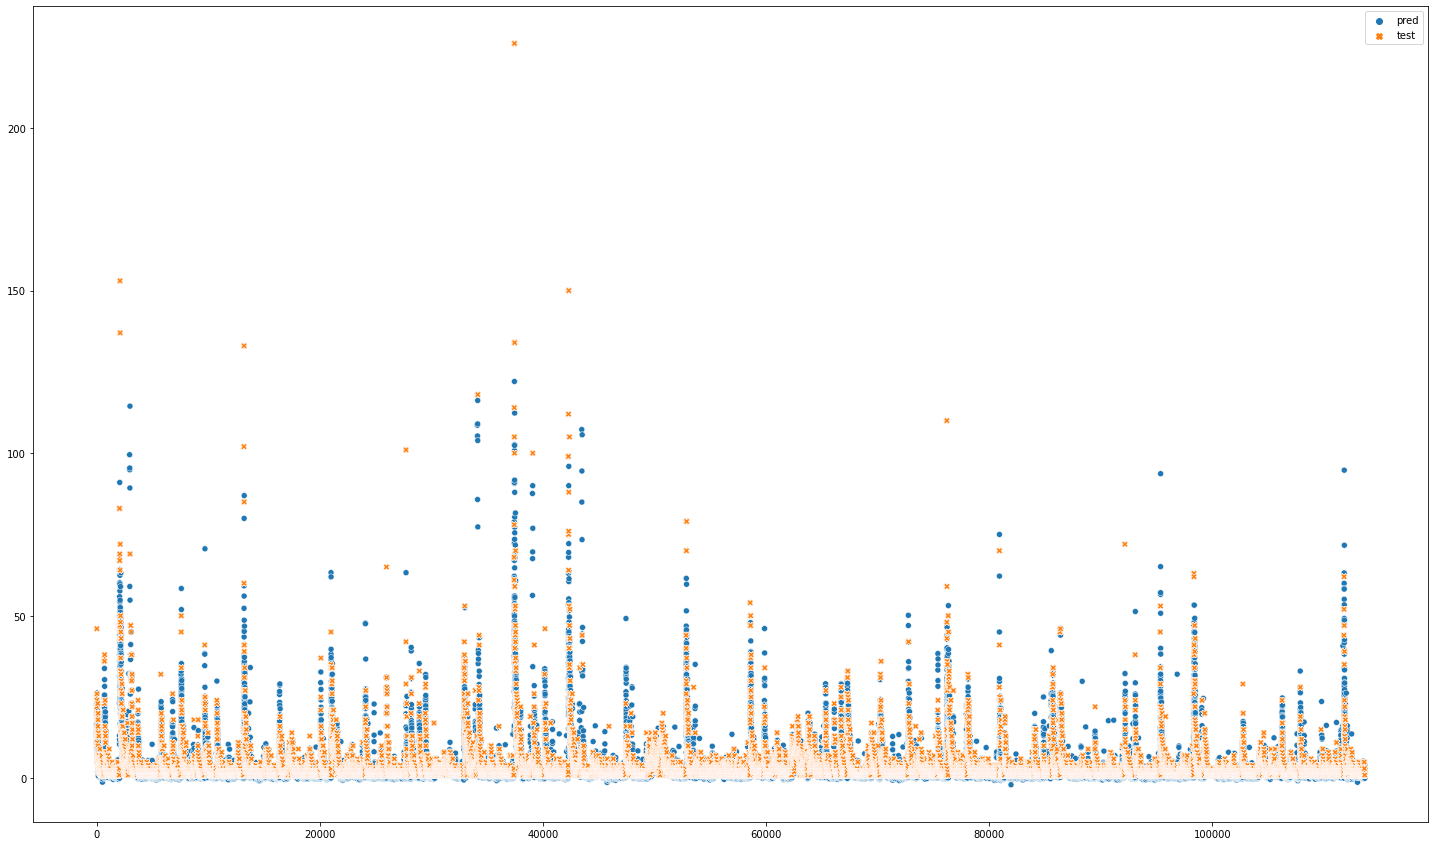

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
condition = np.where(y_test != 0)

df = pd.DataFrame({ 'pred': y_pred[condition],
                    'test':  y_test[condition]})

fig, ax = plt.subplots(figsize = (25, 15))
sns.scatterplot(data = df, ax = ax)

In [17]:
for test, pred in zip(y_test, y_pred):
          print('test:', test)
          print('pred:', np.round(pred))

test: [25. 20. 22. 46. 24. 26. 19.]
pred: [14. 14. 17. 13. 11.  9. 12.]
test: [20. 22. 46. 24. 26. 19. 15.]
pred: [13. 16. 23. 15. 14. 11. 16.]
test: [22. 46. 24. 26. 19. 15. 11.]
pred: [16. 20. 17. 14. 11. 11. 11.]
test: [46. 24. 26. 19. 15. 11. 13.]
pred: [20. 23. 23. 17. 13. 15. 11.]
test: [24. 26. 19. 15. 11. 13. 18.]
pred: [21. 22.  8. 24. 14. 13. 20.]
test: [26. 19. 15. 11. 13. 18. 14.]
pred: [19. 26. 21. 16. 14. 20. 12.]
test: [19. 15. 11. 13. 18. 14.  7.]
pred: [18. 21. 20. 19. 23. 20. 16.]
test: [15. 11. 13. 18. 14.  7.  5.]
pred: [19. 21. 14. 18. 17. 10.  7.]
test: [11. 13. 18. 14.  7.  5. 23.]
pred: [14.  8. 14.  9.  6.  7. 11.]
test: [13. 18. 14.  7.  5. 23.  6.]
pred: [10. 15. 10. 14.  9.  6.  8.]
test: [18. 14.  7.  5. 23.  6. 10.]
pred: [14. 14. 16.  9.  8.  9. 10.]
test: [14.  7.  5. 23.  6. 10. 16.]
pred: [13. 11. 10.  8. 14.  8. 10.]
test: [ 7.  5. 23.  6. 10. 16. 13.]
pred: [14. 12. 10.  8. 11.  5.  7.]
test: [ 5. 23.  6. 10. 16. 13. 18.]
pred: [11.  7.  5.  9.  9. 1

In [18]:
X_test.shape[0]/103

329.0

In [19]:
round(np.random.rand()*100)

21

In [20]:
num = round(np.random.rand()*100)


temp = X_test[day_temp*num + 50:60 + day_temp*num, :17].copy()
print(temp)

temp = y_test[day_temp*num + 50:60 + day_temp*num].copy()
print(temp)


[[ 5.  7.  5.  2.  6.  8.  3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.]
 [ 7.  5.  2.  6.  8.  3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.]
 [ 5.  2.  6.  8.  3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.]
 [ 2.  6.  8.  3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.]
 [ 6.  8.  3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.  3.]
 [ 8.  3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.  3.  4.]
 [ 3.  4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.  3.  4.  6.]
 [ 4.  4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.  3.  4.  6.  3.]
 [ 4.  7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.  3.  4.  6.  3.  3.]
 [ 7.  5.  3.  9.  5.  3. 11.  1.  5.  6.  3.  3.  4.  6.  3.  3.  1.]]
[[2. 6. 4. 4. 3. 2. 5.]
 [6. 4. 4. 3. 2. 5. 7.]
 [4. 4. 3. 2. 5. 7. 5.]
 [4. 3. 2. 5. 7. 5. 4.]
 [3. 2. 5. 7. 5. 4. 2.]
 [2. 5. 7. 5. 4. 2. 6.]
 [5. 7. 5. 4. 2. 6. 5.]
 [7. 5. 4. 2. 6. 5. 5.]
 [5. 4. 2. 6. 5. 5. 5.]
 [4. 2. 6. 5. 5. 5. 8.]]


<AxesSubplot:>

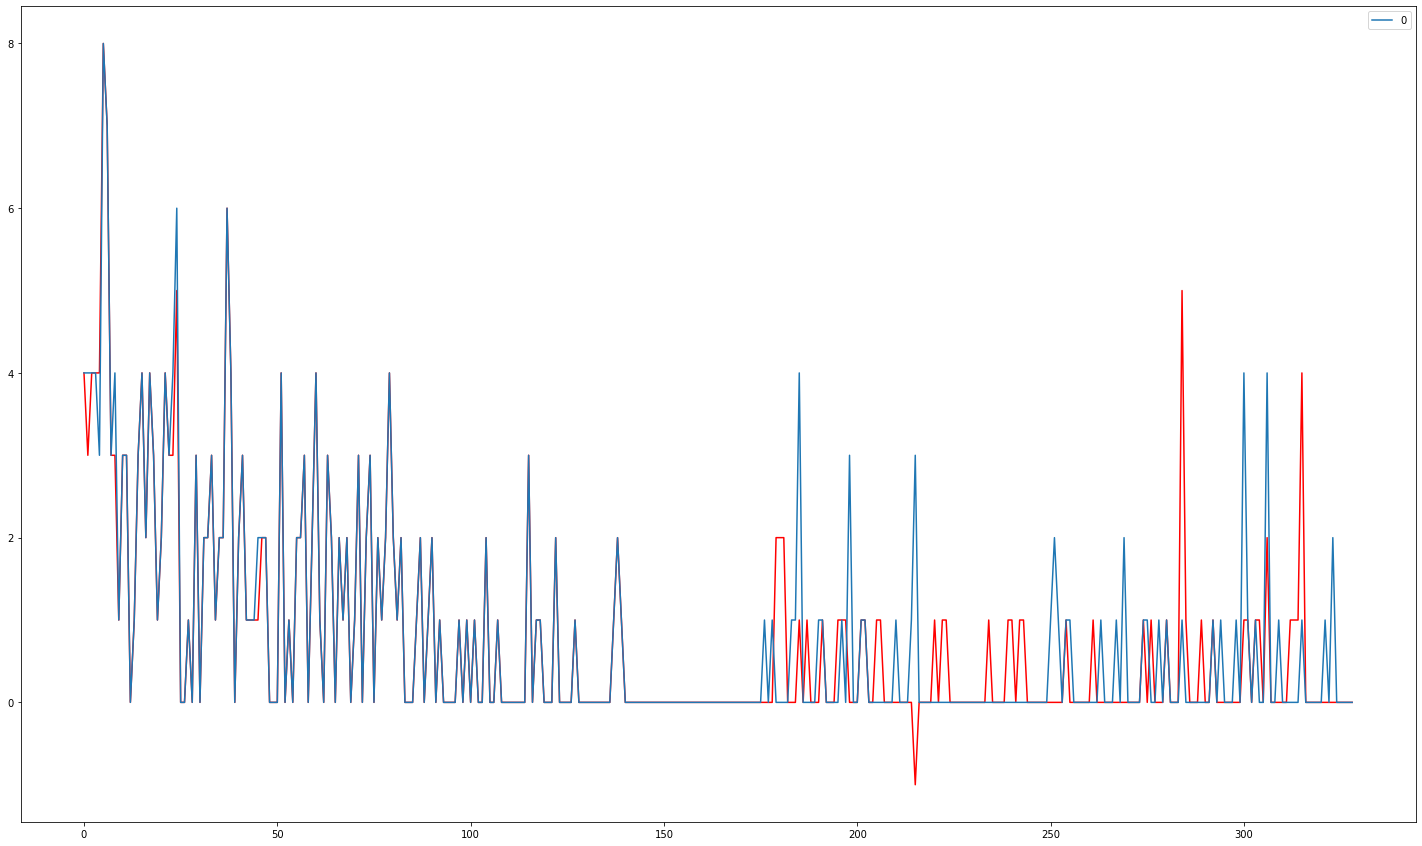

In [163]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'test':  np.random.rand(5)})
df2 = pd.DataFrame({'test':  np.random.rand(5)})

num = round(np.random.rand()*100)

temp = X_test[day_temp*num:day_temp + day_temp*num].copy()
result = y_test[day_temp*num:day_temp + day_temp*num, 0:1].copy()
# result = np.zeros(shape = (day_temp, day_temp))
temp.shape

fig, ax = plt.subplots(figsize = (25, 15))

array = np.zeros(shape = (day_temp, day_temp))
array[:] = np.nan

for i in range(0, day_temp - 7, 7):
          predict = model.predict([temp[i]])

          array[i, i:i+7] = np.round(predict)
          # result[i, i:i+7] = y_test[day_temp*num + i]


array = np.nan_to_num(array)
array = np.sum(array, axis = 0)

sns.lineplot(data = array, ax = ax, color = 'red')

# result = np.nan_to_num(result)
# result = np.sum(result, axis = 0)
# for row in range(array.shape[0]):
#           sns.lineplot(data = array[row], ax = ax)

sns.lineplot(data = result, ax = ax)

<AxesSubplot:>

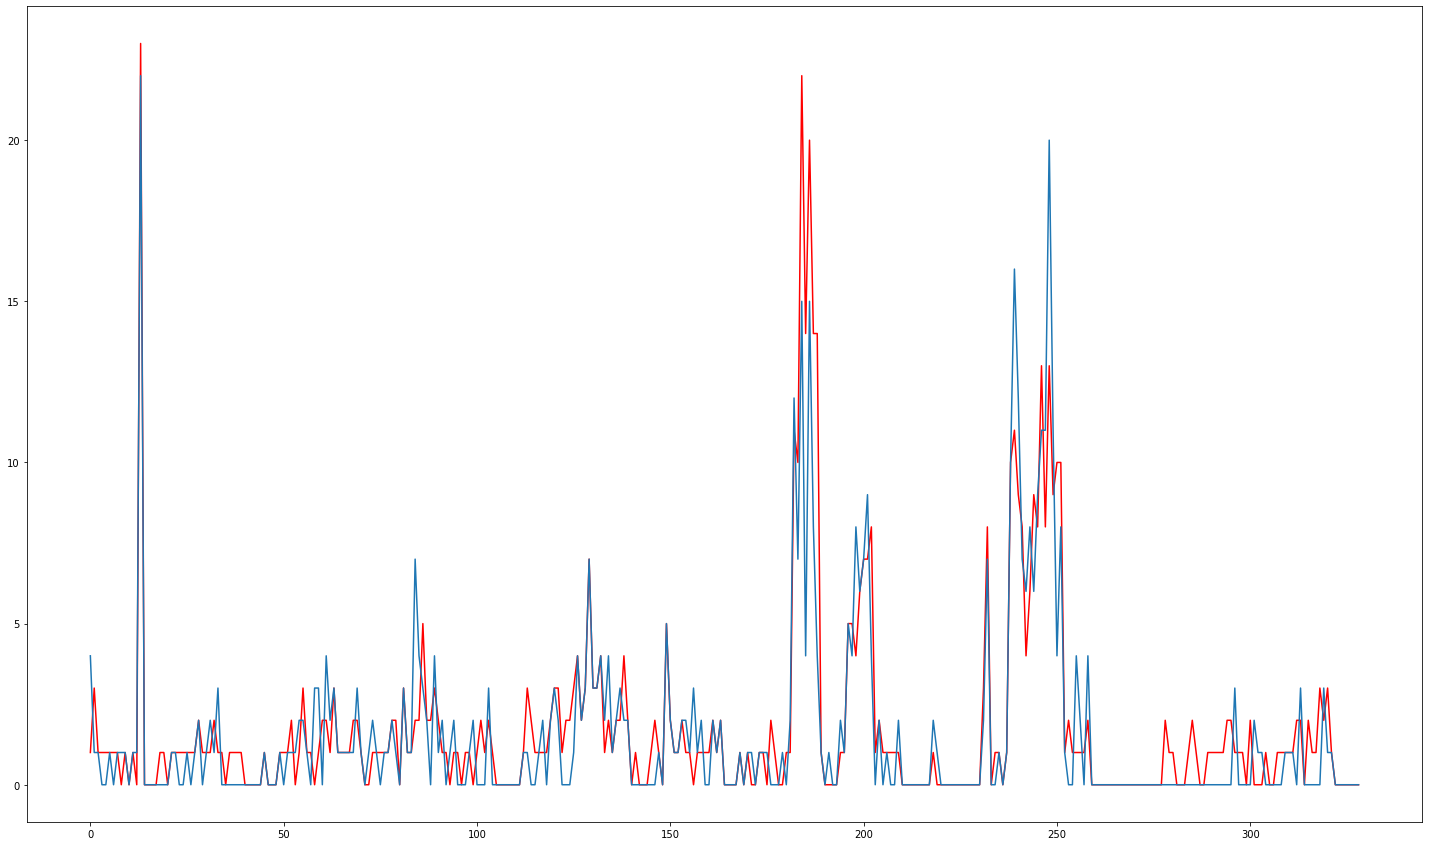

In [107]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'test':  np.random.rand(5)})
df2 = pd.DataFrame({'test':  np.random.rand(5)})

num = round(np.random.rand()*100)

# temp = X_test[day_temp*num:day_temp + day_temp*num].copy()
# result = y_test[day_temp*num:day_temp + day_temp*num, 6:7].copy()

fig, ax = plt.subplots(figsize = (25, 15))

array = np.zeros(shape = (day_temp, day_temp))
result = np.zeros(shape = (day_temp, day_temp))
array[:] = np.nan
result[:] = np.nan

for i in range(0, day_temp - 7, 7):
          num = round(np.random.rand()*33887)
          temp = X_test[num].copy()
          predict = model.predict([temp])

          array[i, i:i+7] = np.round(predict)
          result[i, i:i+7] = y_test[num]

array = np.nan_to_num(array)
array = np.sum(array, axis = 0)

result = np.nan_to_num(result)
result = np.sum(result, axis = 0)

sns.lineplot(data = array, ax = ax, color = 'red')

# for row in range(array.shape[0]):
#           sns.lineplot(data = array[row], ax = ax)

sns.lineplot(data = result, ax = ax)

In [23]:
# Sử dụng độ đo MSE trên mỗi ngày
# make predictions for test data
y_pred = model.predict(X_test)

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))))/(y_pred.shape[0]*y_pred.shape[1])
print('Lỗi trên mỗi ngày: ',error_per_day)

Lỗi trên mỗi ngày:  1.1882968079501013


In [24]:
# Sử dụng độ đo MSE trên mỗi tuần
# make predictions for test data
y_pred = model.predict(X_test)


error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))))/(y_pred.shape[0])
print('Lỗi trên mỗi tuần: ',error_per_day)

Lỗi trên mỗi tuần:  8.31807765565071


In [25]:
y_pred_int = np.asarray(y_pred, dtype = np.int32)
y_pred_int[y_pred_int < 0] = 0

# phần trăm dự đoán đúng những ngày không bán
total = np.sum(y_test == 0)

right = np.sum((y_test == 0) & (y_pred_int == 0))

print('Phần trăm dự đoán đúng những ngày không bán:', right/total)

Phần trăm dự đoán đúng những ngày không bán: 0.7804167273786974


In [26]:
y_test_0 = y_test[y_test == 0]
y_pred_of_test_0 = y_pred[y_test == 0]

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_0, y_test_0))))/(y_pred.shape[0])
print('Lỗi trên mỗi tuần: ',error_per_day)

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_0, y_test_0))))/(y_pred.shape[0]*y_pred.shape[1])
print('Lỗi trên mỗi ngày: ',error_per_day)

Lỗi trên mỗi tuần:  2.4372702477482626
Lỗi trên mỗi ngày:  0.34818146396403754


In [27]:
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 70))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 60))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 50))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 40))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 30))

1
4
8
12
24


In [28]:
# phần trăm dự đoán đúng những ngày có bán
total = np.sum(y_test != 0)

right = np.sum((y_test != 0) & (y_pred_int != 0))

print('Phần trăm dự đoán đúng những ngày có bán:', right/total)

Phần trăm dự đoán đúng những ngày có bán: 0.7167802946998021


In [29]:
y_test_not0 = y_test[y_test != 0]
y_pred_of_test_not0 = y_pred[y_test != 0]

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_not0, y_test_not0))))/(y_pred.shape[0])
print('Lỗi trên mỗi tuần: ',error_per_day)

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_not0, y_test_not0))))/(y_pred.shape[0]*y_pred.shape[1])
print('Lỗi trên mỗi ngày: ',error_per_day)

Lỗi trên mỗi tuần:  5.880807407902447
Lỗi trên mỗi ngày:  0.8401153439860638


In [30]:
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 100))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 90))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 80))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 70))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 60))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 50))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 40))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 30))

38
54
80
109
153
195
307
478


In [31]:
def behon(a1, a2, threshold):
          a = np.subtract(a1, a2)
          b = np.abs(a[a < 0]) > threshold
          return b.sum()

def lonhon(a1, a2, threshold):
          a = np.subtract(a1, a2)
          b = np.abs(a[a > 0]) > threshold
          return b.sum()

In [32]:
print(behon(y_pred_of_test_not0, y_test_not0,100))
print(behon(y_pred_of_test_not0, y_test_not0,90))
print(behon(y_pred_of_test_not0, y_test_not0,80))
print(behon(y_pred_of_test_not0, y_test_not0,70))
print(behon(y_pred_of_test_not0, y_test_not0,60))
print(behon(y_pred_of_test_not0, y_test_not0,50))
print(behon(y_pred_of_test_not0, y_test_not0,40))
print(behon(y_pred_of_test_not0, y_test_not0,30))

38
54
79
108
150
189
294
445


In [33]:
print(lonhon(y_pred_of_test_not0, y_test_not0,100))
print(lonhon(y_pred_of_test_not0, y_test_not0,90))
print(lonhon(y_pred_of_test_not0, y_test_not0,80))
print(lonhon(y_pred_of_test_not0, y_test_not0,70))
print(lonhon(y_pred_of_test_not0, y_test_not0,60))
print(lonhon(y_pred_of_test_not0, y_test_not0,50))
print(lonhon(y_pred_of_test_not0, y_test_not0,40))
print(lonhon(y_pred_of_test_not0, y_test_not0,30))

0
0
1
1
3
6
13
33


In [34]:
def tracking_signal(y_test, y_pred):
          temp1 = np.multiply(np.sum(np.subtract(y_test, y_pred), axis=1), 7)
          temp2 = np.sum(np.abs(np.subtract(y_test, y_pred)), axis = 1)

          result = np.divide(temp1, temp2)
          return result
          pass

sum_int_pred = np.sum(y_pred_int, axis = 1)
sum_int_test = np.sum(y_test, axis = 1)
sum_int_error = np.sum(np.sqrt(np.square(np.subtract(y_pred_int, y_test))), axis = 1)
sum_error = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))), axis = 1)
sum_int_error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_int, y_test))), axis = 1)/7
sum_error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))), axis = 1)/7
sum_error_boolean = np.sum(y_test == y_pred_int, axis = 1)/7
sum_error_sum  = np.abs(np.subtract(sum_int_pred, sum_int_test))
sum_error_tracking_signal = tracking_signal(y_test, y_pred)

In [164]:
# Xác định tăng giảm của đơn hàng trong ngày
y_test_6_day = y_test[:, :6].copy()
x_test_1_day = X_test[:, 29:30].copy()
pre_7_day = np.concatenate((x_test_1_day, y_test_6_day), axis = 1)
pre_7_day.shape

is_higher = y_test >= pre_7_day
is_higher_predict = y_pred_int >= pre_7_day
is_lower = y_test <= pre_7_day
is_lower_predict = y_pred_int <= pre_7_day


sum_acc_higher, soluonghigher = np.sum(is_higher_predict & is_higher, axis = 1), np.sum(is_higher, axis = 1)
sum_acc_lower, soluonglower = np.sum(is_lower_predict & is_lower, axis = 1), np.sum(is_lower, axis = 1)


# Dự đoán bán và không bán
def khongban(a, b):
          temp1 = a == 0
          temp2 = b == 0

          return np.sum(temp1 & temp2, axis = 1), np.sum(temp1, axis = 1), np.sum(temp2, axis = 1)


def coban(a, b):
          temp1 = (a != 0)
          temp2 = (b != 0)

          return np.sum(temp1 & temp2, axis = 1), np.sum(temp1, axis = 1), np.sum(temp2, axis = 1)

doandungkhongban, soluogkhongban_model, soluogkhongban_pred = khongban(y_test, y_pred_int)
doandungcoban, soluogcoban_model, soluogcoban_pred = coban(y_test, y_pred_int)


In [165]:
threshold = 50
condition = sum_int_test > threshold
print(f'Có {len(sum_int_test[condition])} sản phẩm thỏa điều kiện > {threshold}')
print(f'Độ lỗi sum_int_error trung bình ở {threshold} là:',sum_int_error[condition].mean())
print(f'Độ lỗi sum_error trung bình ở {threshold} là:',sum_error[condition].mean())
print(f'Độ lỗi sum_int_error_per_day trung bình ở {threshold} là:',sum_int_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_per_day trung bình ở {threshold} là:',sum_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_tracking_signal trung bình ở {threshold} là:',sum_error_tracking_signal[condition].mean())
# print(f'Độ lỗi sum_error_boolean trung bình ở {threshold} là:',sum_error_boolean[condition].mean())
print(f'Độ lỗi sum_error_sum trung bình ở {threshold} là:',sum_error_sum[condition].mean())
print(f'Độ lỗi sum_acc_higher trung bình ở {threshold} là:',sum_acc_higher[condition].sum()/soluonghigher[condition].sum())
print(f'Độ lỗi sum_acc_lower trung bình ở {threshold} là:',sum_acc_lower[condition].sum()/soluonglower[condition].sum())
print(f'Đoán đúng (precision) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_pred[condition].sum())
print(f'Đoán đúng (recall) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_model[condition].sum())
print(f'Đoán đúng (precision) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_pred[condition].sum())
print(f'Đoán đúng (recall) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_model[condition].sum())

Có 1622 sản phẩm thỏa điều kiện > 50
Độ lỗi sum_int_error trung bình ở 50 là: 53.097410604192355
Độ lỗi sum_error trung bình ở 50 là: 51.87328819674413
Độ lỗi sum_int_error_per_day trung bình ở 50 là: 7.585344372027479
Độ lỗi sum_error_per_day trung bình ở 50 là: 7.410469742392018
Độ lỗi sum_error_tracking_signal trung bình ở 50 là: 2.9715470398855164
Độ lỗi sum_error_sum trung bình ở 50 là: 43.159062885326755
Độ lỗi sum_acc_higher trung bình ở 50 là: 0.5966524450278963
Độ lỗi sum_acc_lower trung bình ở 50 là: 0.8689086096839483
Đoán đúng (precision) không bán trung bình ở 50 là: 0.4293193717277487
Đoán đúng (recall) không bán trung bình ở 50 là: 0.7256637168141593
Đoán đúng (precision) có bán trung bình ở 50 là: 0.985094720646216
Đoán đúng (recall) có bán trung bình ở 50 là: 0.9494855871721197


In [166]:
threshold = 0
condition = sum_int_test >= threshold
print(f'Có {len(sum_int_test[condition])} sản phẩm thỏa điều kiện >= {threshold}')
print(f'Độ lỗi sum_int_error trung bình ở {threshold} là:',sum_int_error[condition].mean())
print(f'Độ lỗi sum_error trung bình ở {threshold} là:',sum_error[condition].mean())
print(f'Độ lỗi sum_int_error_per_day trung bình ở {threshold} là:',sum_int_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_per_day trung bình ở {threshold} là:',sum_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_tracking_signal trung bình ở {threshold} là:',sum_error_tracking_signal[condition].mean())
# print(f'Độ lỗi sum_error_boolean trung bình ở {threshold} là:',sum_error_boolean[condition].mean())
print(f'Độ lỗi sum_error_sum trung bình ở {threshold} là:',sum_error_sum[condition].mean())
print(f'Độ lỗi sum_acc_higher trung bình ở {threshold} là:',sum_acc_higher[condition].sum()/soluonghigher.sum())
print(f'Độ lỗi sum_acc_lower trung bình ở {threshold} là:',sum_acc_lower[condition].sum()/soluonglower.sum())
print(f'Đoán đúng (precision) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_pred[condition].sum())
print(f'Đoán đúng (recall) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_model[condition].sum())
print(f'Đoán đúng (precision) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_pred[condition].sum())
print(f'Đoán đúng (recall) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_model[condition].sum())

# Với những ngày bán lớn hơn một lượng hàng thì chênh lệch là bao nhiêu
# Làm một độ đo xem là nhựng cực trí cực đại cực tiểu trong khỏang 3 ngày của predict có trùng với test hay không.


Có 33887 sản phẩm thỏa điều kiện >= 0
Độ lỗi sum_int_error trung bình ở 0 là: 7.902528993419305
Độ lỗi sum_error trung bình ở 0 là: 8.318077655650711
Độ lỗi sum_int_error_per_day trung bình ở 0 là: 1.128932713345615
Độ lỗi sum_error_per_day trung bình ở 0 là: 1.1882968079501013
Độ lỗi sum_error_tracking_signal trung bình ở 0 là: -1.621420437279508
Độ lỗi sum_error_sum trung bình ở 0 là: 5.755097825124679
Độ lỗi sum_acc_higher trung bình ở 0 là: 0.8683957240570201
Độ lỗi sum_acc_lower trung bình ở 0 là: 0.8725220638153428
Đoán đúng (precision) không bán trung bình ở 0 là: 0.749655917824623
Đoán đúng (recall) không bán trung bình ở 0 là: 0.7804167273786974
Đoán đúng (precision) có bán trung bình ở 0 là: 0.750234793657809
Đoán đúng (recall) có bán trung bình ở 0 là: 0.7167802946998021


In [101]:
def find_max_min_local(series, threshold = 20):
        """
            Input: 
                series: list
            Return:
                list of index
        """
        result = []
        for i in range(1, len(series) - 1):
            if series[i] > series[i - 1] and series[i] > series[i + 1]:
                temp = series[i]*2 - series[i - 1] - series[i + 1]
                if temp > threshold:
                    result.append(i)
            # elif series[i] < series[i - 1] and series[i] < series[i + 1]: 
            #     temp = series[i - 1] + series[i + 1] - series[i]*2
            #     if temp > threshold:
            #         result.append(i)
        return result

def mo_rong_pham_vi(test_max):
    temp = test_max.copy()
    for index in temp:
            test_max.append(index+1)
            test_max.append(index-1)
    return test_max


total_model = 0
total_pred = 0
correct = 0

true_positive = 0 # The model predicted a label and matches correctly as per ground truth.
true_negative = 0  # The model does not predict the label and is not a part of the ground truth.
false_positive = 0 # The model predicted a label, but it is not a part of the ground truth (Type I Error).
false_negative = 0 # The model does not predict a label, but it is part of the ground truth. (Type II Error).

for i in range(len(y_test)):
    test_max = find_max_min_local(y_test[i], 50)
    # Cộng số ngày cực đại vào total
    total_model = len(test_max)

    test_pred = find_max_min_local(y_pred[i], 20)
    # Mở rộng phạm vi để lấy số ngày trùng nhau giữa dự đoán và groundtruth
    test_pred = mo_rong_pham_vi(test_pred)
    total_pred = len(set(test_pred))

    # Đếm số ngày trùng nhau
    true_positive += len(np.intersect1d(test_max,test_pred))
    false_positive += total_pred - len(np.intersect1d(test_max,test_pred))
    true_negative += 0
    false_negative += total_model - len(np.intersect1d(test_max,test_pred))

print("Ngưỡng cực đại test: 50, ở pred là 20")
print('Tỉ lệ cực đại trùng precision:',true_positive/(true_positive + false_positive))
print('Tỉ lệ cực đại trùng recall:',true_positive/(true_positive + false_negative))



Ngưỡng cực đại test: 50, ở pred là 20
Tỉ lệ cực đại trùng precision: 0.05183585313174946
Tỉ lệ cực đại trùng recall: 0.3829787234042553


In [102]:
total_model = 0
total_pred = 0
correct = 0

true_positive = 0 # The model predicted a label and matches correctly as per ground truth.
true_negative = 0  # The model does not predict the label and is not a part of the ground truth.
false_positive = 0 # The model predicted a label, but it is not a part of the ground truth (Type I Error).
false_negative = 0 # The model does not predict a label, but it is part of the ground truth. (Type II Error).

for i in range(len(y_test)):
    test_max = find_max_min_local(y_test[i], 200)
    # Cộng số ngày cực đại vào total
    total_model = len(test_max)

    test_pred = find_max_min_local(y_pred[i], 100)
    # Mở rộng phạm vi để lấy số ngày trùng nhau giữa dự đoán và groundtruth
    test_pred = mo_rong_pham_vi(test_pred)
    total_pred = len(set(test_pred))

    # Đếm số ngày trùng nhau
    true_positive += len(np.intersect1d(test_max,test_pred))
    false_positive += total_pred - len(np.intersect1d(test_max,test_pred))
    true_negative += 0
    false_negative += total_model - len(np.intersect1d(test_max,test_pred))

print("Ngưỡng cực đại test: 200, ở pred là 100")
print('Tỉ lệ cực đại trùng precision:',true_positive/(true_positive + false_positive))
print('Tỉ lệ cực đại trùng recall:',true_positive/(true_positive + false_negative))


Ngưỡng cực đại test: 200, ở pred là 100
Tỉ lệ cực đại trùng precision: 0.07936507936507936
Tỉ lệ cực đại trùng recall: 0.5


In [106]:
from scipy import stats

total_model = 0
total_pred = 0
correct = 0

true_positive = 0 # The model predicted a label and matches correctly as per ground truth.
true_negative = 0  # The model does not predict the label and is not a part of the ground truth.
false_positive = 0 # The model predicted a label, but it is not a part of the ground truth (Type I Error).
false_negative = 0 # The model does not predict a label, but it is part of the ground truth. (Type II Error).

for num in range(int(len(y_test)/day_temp)):
          temp_test = y_test[day_temp*num:day_temp + day_temp*num:7].copy()
          temp_pred = y_pred[day_temp*num:day_temp + day_temp*num:7].copy()

          zscore_temp = np.abs(stats.zscore(temp_test, axis = None)) > 5
          zscore_pred = np.abs(stats.zscore(temp_pred, axis = None)) > 4

          total_model = zscore_temp.sum()
          total_pred = zscore_pred.sum()

          correct = (zscore_pred[zscore_temp == True] == True).sum()

          true_positive += correct
          false_positive += total_pred - correct
          true_negative += 0
          false_negative += total_model - correct

print("Ngưỡng cực đại test: 5, ở pred là 4 (t-distribution)")
print('Tỉ lệ đột biến trùng precision:',true_positive/(true_positive + false_positive))
print('Tỉ lệ đột biến trùng recall:',true_positive/(true_positive + false_negative))

Ngưỡng cực đại test: 5, ở pred là 4 (t-distribution)
Tỉ lệ đột biến trùng precision: 0.24040920716112532
Tỉ lệ đột biến trùng recall: 0.48205128205128206


### Model dự đoán có bán hay không

In [43]:
from xgboost import XGBClassifier

y_train_classifier = y_train > 0
y_test_classifier = y_test > 0

model_classifier = XGBClassifier(tree_method = 'hist')
model_classifier.fit(X_train, y_train_classifier)

y_pred_classifier = model_classifier.predict(X_test)


y_test_classifier = np.asarray(y_test_classifier, dtype = np.int32)
y_pred_classifier = np.asarray(y_pred_classifier, dtype = np.int32)

print('Phần trăm dự đoán tổng thể')
print(np.sum(y_test_classifier == y_pred_classifier)/(y_test_classifier.shape[0]*y_test_classifier.shape[1]))

condition = y_test_classifier == 1
total = np.sum(y_test_classifier[condition])
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)

condition = y_test == 0
temp = y_test[condition]
temp[:] = 1
total = np.sum(temp)
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)


Phần trăm dự đoán tổng thể
0.786302374699105
Phần trăm dự đoán label
113675
0.8022080492632505
Phần trăm dự đoán label
123534.0
0.7716661000210469


In [44]:
from xgboost import XGBClassifier

y_train_classifier = np.zeros(shape = y_train.shape)
y_test_classifier = np.zeros(shape = y_test.shape)

for num in range(int(len(y_train)/day_temp)):
          temp_train = y_train[day_temp*num:day_temp + day_temp*num].copy()
          y_train_classifier[day_temp*num:day_temp + day_temp*num] = np.abs(stats.zscore(temp_train, axis = 0)) > 3

for num in range(int(len(y_test)/day_temp)):
          temp_test = y_test[day_temp*num:day_temp + day_temp*num].copy()
          y_test_classifier[day_temp*num:day_temp + day_temp*num] = np.abs(stats.zscore(temp_test, axis = 0)) > 2

model_classifier = XGBClassifier(tree_method = 'hist')
model_classifier.fit(X_train, y_train_classifier)

y_pred_classifier = model_classifier.predict(X_test)


y_test_classifier = np.asarray(y_test_classifier, dtype = np.int32)
y_pred_classifier = np.asarray(y_pred_classifier, dtype = np.int32)

print('Phần trăm dự đoán tổng thể')
print(np.sum(y_test_classifier == y_pred_classifier)/(y_test_classifier.shape[0]*y_test_classifier.shape[1]))

condition = y_test_classifier == 1
total = np.sum(y_test_classifier[condition])
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)

condition = y_test_classifier == 0
temp = y_test[condition]
temp[:] = 1
total = np.sum(temp)
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)

Phần trăm dự đoán tổng thể
0.9637619145985186
Phần trăm dự đoán label
10362
0.1977417486971627
Phần trăm dự đoán label
226847.0
0.998752463113905


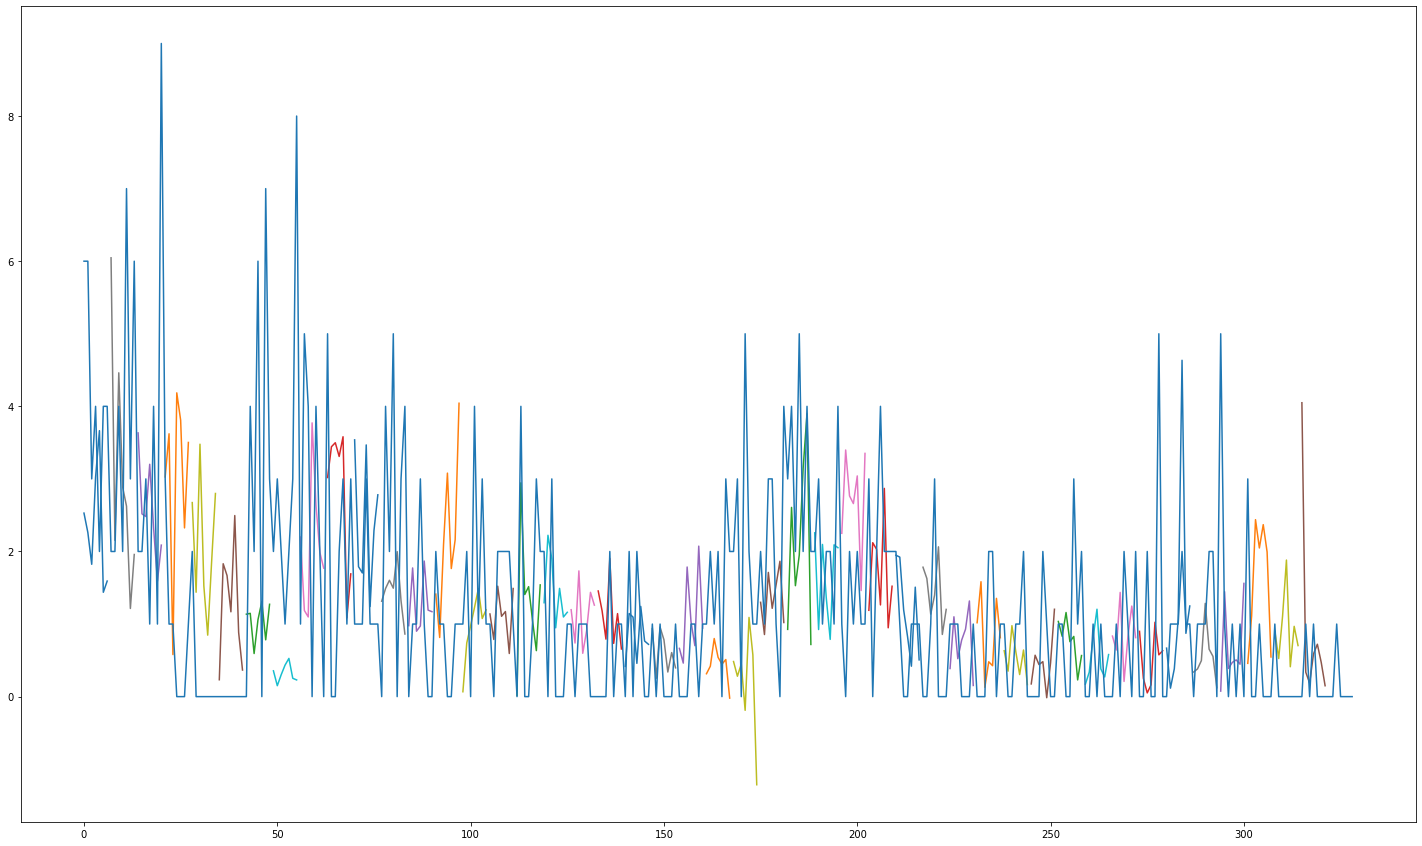

In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'test':  np.random.rand(5)})
df2 = pd.DataFrame({'test':  np.random.rand(5)})


temp = X_test[day_temp*num:day_temp + day_temp*num].copy()
result = y_test[day_temp*num:day_temp + day_temp*num, 6:7].copy()
temp.shape

fig, ax = plt.subplots(figsize = (25, 15))

array = np.zeros(shape = (day_temp, day_temp))
array[:] = np.nan

for i in range(0, day_temp - 7, 7):
          predict = model.predict([temp[i]])

          array[i, i:i+7] = predict

# array = np.nan_to_num(array)

# array = np.sum(array, axis = 0)
sns.lineplot(data = array, ax = ax, color = 'red')

for row in range(array.shape[0]):
          sns.lineplot(data = array[row], ax = ax)

sns.lineplot(data = result, ax = ax)
ax.get_legend().remove()